# Initial version 23 March 2022
 - Create a synthetic example
 - Fit an SEM
 - Calculate calculate p-values
 - Correct for multiplicity
 - Comunicate results graphically
 - Backwards SCM contruction

# 02 Aug 2022 - repace sempoy with dowhy [pywhy] & clean code
# 09 Aug 2022 - bootstrap function
# 18 Aug 2022 - continue on replacing sempoy with dowhy using the functions created for the dowhy pull request
# 23 Aug 2022 - change the example to a simpler and clearere setting


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.precision',4)
pd.options.display.max_rows = 20
import copy

#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error # need this also for the SCM
#import statsmodels.api as sm


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
## Standerdized plotiing
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.figure(figsize=(5, 5))
sns.set_style('white')
AvaOrangeLight = "#FF5800"
AvaOrangeDark  = "#DC4600"
AvaGoldLight = "#FFB414"
AvaGoldDark  = "#E6A61C"

# DoWhy
from dowhy import CausalModel
import dowhy.datasets
from dowhy import gcm
from dowhy.gcm import refute_causal_structure
import networkx as nx # required for defining the SCM in gcm & could be used also for plotting
gcm.config.disable_progress_bars() # we will be running loads of gcm.fit during the bootstap

import random
from scipy.stats import ttest_1samp # for t-test in the bootstap loop

<Figure size 360x360 with 0 Axes>

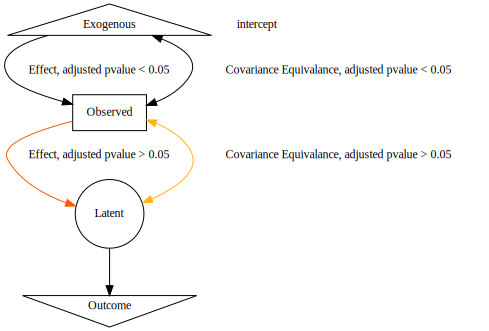

In [2]:
#Import utility functions
import false_discovery_rate_control
from false_discovery_rate_control import adjusted_FDR_pvalues, adjusted_FDCR_pvalues
import scm_plots
from scm_plots import scm_results_plot
from scm_plots import scm_induced_covariances_plot

In [3]:
# Toy data deliberatly simple using mainly gausian relatiohips and a variable that is not really participating in the system.
# The example is of deciding how fust to turn a wind-turbine where the outcomes are energy produced and percived noise.
# https://www.sciencedirect.com/science/article/pii/S0960148113005727#:~:text=Wind%20turbines%20are%20found%20to,design%20and%20individual%20wind%20farms.
# "By accounting for individual site conditions we confirm that load factors do decline with age, at a similar rate to other rotating machinery. Wind turbines are found to lose 1.6 ± 0.2% of their output per year, with average load factors declining from 28.5% when new to 21% at age 19. This trend is consistent for different generations of turbine design and individual wind farms. This level of degradation reduces a wind farm's output by 12% over a twenty year lifetime, increasing the levelised cost of electricity by 9%."

np.random.seed(seed=853210)

n_samples = 20000

Winter_Ind                     = np.random.binomial  (n=1                                                        , p=0.7                  , size=n_samples)
Sea_Temperature                = np.random.normal    (loc = 20 - Winter_Ind*10                                   , scale = 2              , size=n_samples)
Wind_Speed                     = np.random.normal    (loc = 40 + Winter_Ind*20                                   , scale = 10             , size=n_samples)
Strenght_Degradation           = np.random.normal    (loc = 1.5                                                  , scale= 0.1             , size=n_samples)
Rotational_RPM                 = np.random.normal    (loc = 1.200 + Wind_Speed * 0.10                            , scale= 0.20            , size=n_samples) #*1000
Energy_Yield                   = np.random.normal    (loc = 10 + Rotational_RPM/1.500 - Strenght_Degradation/10  , scale= 2               , size=n_samples) #Cent/kWh
Perceived_Noise                = np.random.normal    (loc = 20 + Rotational_RPM/1.500 - Wind_Speed/4             , scale= 1               , size=n_samples) #Cent/kWh


toy_example = pd.DataFrame(data=dict(Winter_Ind              = Winter_Ind,
                                     Sea_Temperature         = Sea_Temperature,
                                     Wind_Speed              = Wind_Speed,
                                     Strenght_Degradation    = Strenght_Degradation,
                                     Rotational_RPM          = Rotational_RPM,
                                     Energy_Yield            = Energy_Yield,
                                     Perceived_Noise         =Perceived_Noise
                                     ))
print(toy_example.head())

varList = ["Winter_Ind", "Sea_Temperature", "Wind_Speed", "Strenght_Degradation",  "Rotational_RPM", "Energy_Yield","Perceived_Noise"]


   Winter_Ind  Sea_Temperature  Wind_Speed  Strenght_Degradation  \
0           1          11.1620     71.1992                1.5068   
1           0          19.4641     30.8234                1.5701   
2           1          12.0031     49.2627                1.5064   
3           0          20.8129     55.7235                1.3467   
4           1           9.3319     63.5002                1.3723   

   Rotational_RPM  Energy_Yield  Perceived_Noise  
0          8.1608       16.6452           6.8877  
1          4.2899       10.8510          13.8079  
2          6.1397       12.0759          11.2544  
3          7.3132       15.2318          10.3084  
4          7.5652       17.4092           8.7434  


In [4]:
df = copy.copy(toy_example)
df = df.reset_index(drop=True) # just to be on the safe side

df_numerics=copy.copy(df) #keep a version withouth typeing the categorical vars.
#the automodel identifiyes categorical variables if they are corretly typed and we need this in anycase for corretly modeling 0 & 1
df.Winter_Ind = df.Winter_Ind.astype("category")

# Get a feel for the data

In [5]:
df.describe()

,Sea_Temperature,Wind_Speed,Strenght_Degradation,Rotational_RPM,Energy_Yield,Perceived_Noise
count,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000
mean,13.0098,53.9189,1.5000,6.5929,14.2364,10.9112
std,4.9972,13.6006,0.0996,1.3748,2.1839,2.6941
min,2.5777,1.7188,1.1157,0.9906,5.3843,1.8717
25%,9.2819,44.7813,1.4323,5.6754,12.7858,8.9984
50%,11.1523,54.9097,1.4992,6.6899,14.2478,10.7695
75%,18.1513,63.6054,1.5680,7.5799,15.7052,12.7371
max,27.5690,95.2571,1.8986,10.8433,23.7086,20.8344


In [6]:
df.var()

<ipython-input-6-28ded241fd7c>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.var()


Sea_Temperature          24.9723
Wind_Speed              184.9767
Strenght_Degradation      0.0099
Rotational_RPM            1.8901
Energy_Yield              4.7693
Perceived_Noise           7.2582
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82b22b01f0>,
      dtype=object)

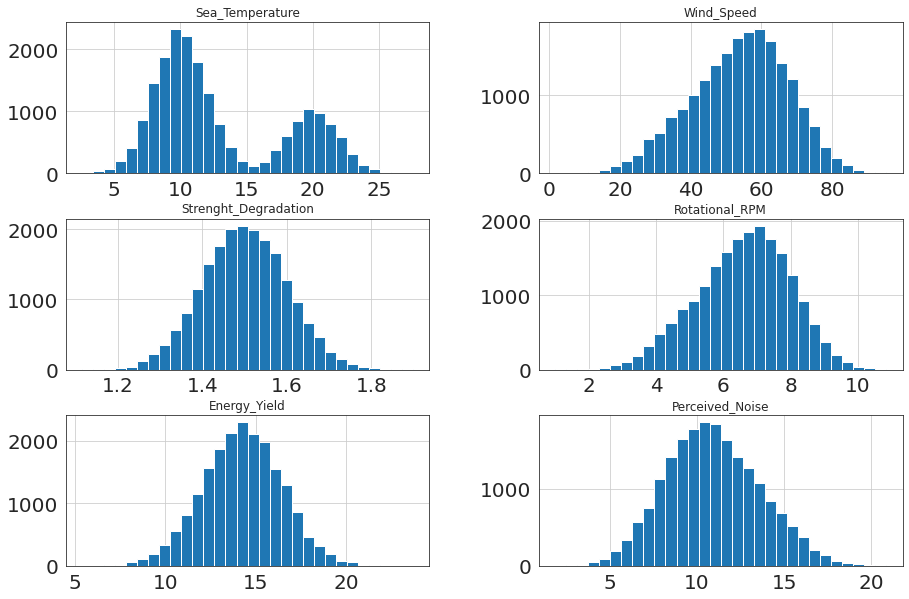

In [7]:
df.hist(bins=30, figsize=(15, 10))

In [8]:
corr = df_numerics.corr()

cmap=sns.diverging_palette(220, 20, n=20,as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())



<ipython-input-8-e2a969b3bda5>:17: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap, axis=1)\


,Winter_Ind,Sea_Temperature,Wind_Speed,Strenght_Degradation,Rotational_RPM,Energy_Yield,Perceived_Noise
Winter_Ind,1.00,-0.92,0.67,-0.00,0.67,0.28,-0.62
Sea_Temperature,-0.92,1.00,-0.62,0.01,-0.61,-0.25,0.57
Wind_Speed,0.67,-0.62,1.00,0.00,0.99,0.41,-0.93
Strenght_Degradation,-0.00,0.01,0.00,1.00,0.00,-0.01,-0.00
Rotational_RPM,0.67,-0.61,0.99,0.00,1.00,0.42,-0.91
Energy_Yield,0.28,-0.25,0.41,-0.01,0.42,1.00,-0.38
Perceived_Noise,-0.62,0.57,-0.93,-0.00,-0.91,-0.38,1.00


# +++++++++  Bootstup correlation pvalue ++++++++++++++++++++++++++

In [9]:
def bootPvalCorr(var1,var2):
    ''' get pvalue for correlation where H0: R2=0 '''
    bothDS = pd.concat([var1,var2],axis=1).reset_index(drop=True)
    obsCorr=bothDS.corr().iloc[0,1]
    obsR2 = obsCorr * obsCorr
    
    counter = 0 
    B=2000
    Sum = 0
    for i in range(B):
        bootstrapped_var1 = pd.DataFrame( np.random.choice(var1, len(var1)))
        bootstrapped_var2 = pd.DataFrame( np.random.choice(var2, len(var2)))
        bothDS = pd.concat([bootstrapped_var1,bootstrapped_var2],axis=1).reset_index(drop=True)
        Corr=bothDS.corr().iloc[0,1]
        Sum = Sum + Corr
        R2 = Corr * Corr
        if R2 >= obsR2:
            counter = counter + 1
        
    return obsCorr, Sum/B, obsR2, counter/B

In [10]:
#loop through pairs of variables and calculate corr and p - value
NVars=len(df_numerics.columns)
results = []
for i in range(NVars):
    Var1 = df_numerics.iloc[:,i]
    for j in range(i+1,NVars):
        Var2 = df_numerics.iloc[:,j]
        obsCorr, BoodCorr, obsR2, pval = bootPvalCorr(Var1, Var2)
        V1=str(i+1)+". "+Var1.name
        V2=str(j+1)+". "+Var2.name
        row =[i,j, Var1.name, Var2.name, V1, V2, obsCorr, obsR2, pval]
        results.append(row)
resultsDS = pd.DataFrame(results)
resultsDS.columns=["i","j","var1","var2", "V1", "V2", "Corr", "R2", "pvalue"]

resultsDS.to_csv("resultsDS.csv")
#print(resultsDS)

In [11]:
resultsDS.groupby(['V1', 'V2'])['Corr'].mean().unstack() #.fillna(0)

V2,2. Sea_Temperature,3. Wind_Speed,4. Strenght_Degradation,5. Rotational_RPM,6. Energy_Yield,7. Perceived_Noise
V1,,,,,,
1. Winter_Ind,-0.9172,0.6737,-0.0038,0.6669,0.2767,-0.6174
2. Sea_Temperature,NaN,-0.6171,0.0061,-0.6106,-0.2539,0.5663
3. Wind_Speed,NaN,NaN,0.0022,0.9893,0.4126,-0.9260
4. Strenght_Degradation,NaN,NaN,NaN,0.0013,-0.0053,-0.0010
5. Rotational_RPM,NaN,NaN,NaN,NaN,0.4178,-0.9091
6. Energy_Yield,NaN,NaN,NaN,NaN,NaN,-0.3761


In [12]:
resultsDS.groupby(['V1', 'V2'])['R2'].mean().unstack()

V2,2. Sea_Temperature,3. Wind_Speed,4. Strenght_Degradation,5. Rotational_RPM,6. Energy_Yield,7. Perceived_Noise
V1,,,,,,
1. Winter_Ind,0.8413,0.4539,1.4630e-05,4.4474e-01,7.6540e-02,3.8117e-01
2. Sea_Temperature,NaN,0.3808,3.6883e-05,3.7280e-01,6.4462e-02,3.2070e-01
3. Wind_Speed,NaN,NaN,4.7284e-06,9.7876e-01,1.7021e-01,8.5754e-01
4. Strenght_Degradation,NaN,NaN,NaN,1.5985e-06,2.8009e-05,1.0446e-06
5. Rotational_RPM,NaN,NaN,NaN,NaN,1.7459e-01,8.2642e-01
6. Energy_Yield,NaN,NaN,NaN,NaN,NaN,1.4148e-01


In [13]:
resultsDS.groupby(['V1', 'V2'])['pvalue'].mean().unstack()

V2,2. Sea_Temperature,3. Wind_Speed,4. Strenght_Degradation,5. Rotational_RPM,6. Energy_Yield,7. Perceived_Noise
V1,,,,,,
1. Winter_Ind,0.0,0.0,0.586,0.0000,0.0000,0.0000
2. Sea_Temperature,NaN,0.0,0.400,0.0000,0.0000,0.0000
3. Wind_Speed,NaN,NaN,0.753,0.0000,0.0000,0.0000
4. Strenght_Degradation,NaN,NaN,NaN,0.8555,0.4655,0.8865
5. Rotational_RPM,NaN,NaN,NaN,NaN,0.0000,0.0000
6. Energy_Yield,NaN,NaN,NaN,NaN,NaN,0.0000


In [14]:
resultsDS['adjBHpvalue'] = adjusted_FDR_pvalues(resultsDS['pvalue'])
resultsDS.groupby(['V1', 'V2'])['adjBHpvalue'].mean().unstack()

V2,2. Sea_Temperature,3. Wind_Speed,4. Strenght_Degradation,5. Rotational_RPM,6. Energy_Yield,7. Perceived_Noise
V1,,,,,,
1. Winter_Ind,0.0,0.0,0.6837,0.0000,0.000,0.0000
2. Sea_Temperature,NaN,0.0,0.5250,0.0000,0.000,0.0000
3. Wind_Speed,NaN,NaN,0.8323,0.0000,0.000,0.0000
4. Strenght_Degradation,NaN,NaN,NaN,0.8865,0.575,0.8865
5. Rotational_RPM,NaN,NaN,NaN,NaN,0.000,0.0000
6. Energy_Yield,NaN,NaN,NaN,NaN,NaN,0.0000


# Define Bootstrap the p-values for the coefficients and the compare induced correlation matrices to expected
## Bootstrap loop;
## sample from the data
## correlation matrix
## fit model
## get coefficients
## get induced correlation matrix from drawn samples
## apply FDCR adjustment to the p-values

In [15]:
def bootstrap_scms_FDCR(n_boot, input_df, scm_parameters_func, scm_parameter_names, belifeDic):
    ''' This is written for the purpose of the example in this notebook. Much more work needs to be done to generalise it.
        The output DataFrame complies with the structure obtained while using sempoy and is used as input for the visualisation functions

        Param: n_boot - number of bootstap iterations
        Param: input_df - Pandas datafream with the varialbes that are hard coded bellow
        Param: scm_parameters_func - a function matched to the SCM mapping the coeficnets [retuns list with an expected order]
        Param: scm_parameter_names - ordered list labeling the output of scm_parameters_func
        Param: belifeDic - dictionary assigning belife weights to edges
        
        Return: Pandas dataframe with parameter estimates, raw p-values and FDR adjusted p-values
        '''

    import statsmodels.stats.weightstats as ssws # for TOST

    origianl_df = copy.copy(input_df)
    df_nobs = origianl_df.shape[0]
    # df_ncols = origianl_df.shape[1] - as there is Rain_ind & Rain_ind_Cat we really need to only count the numeric fields
    # the order is important as the tranlge will be vectorised and the position has a meaning
    df_columns=origianl_df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64','category']).columns.tolist()
    #print("df_columns")
    #print(df_columns)
    df_ncols=len(df_columns)

    #W hen looking at the covariance matrix we need only the upper triangle, including the diagonal. It is more efficiant to flatten it.
    n_covariaces = int(df_ncols * (df_ncols-1) / 2 + df_ncols)

    bootstapped_covariances_list = []
    SCM_covariances_list = []
    scm_parameters = []
    for ib in range(n_boot):
        # sample form the data - no need to apply null hypotheisis conditions (no correlations at all) as we want the mean and std of the coefficants and assume we know that the null distibution of noise is normal
        # one can use sample but stackoverflow suggests this approach is more efficiant
        random_pointers = pd.DataFrame(index=np.random.randint(df_nobs, size=df_nobs))
        bootstrap_df = origianl_df.merge(random_pointers, left_index=True, right_index=True, how='right')
        
        # fit the scm & get the parameters
        gcm.fit(scm, bootstrap_df)
        scm_parameters_bi = scm_parameters_func(scm)
        scm_parameters.append(scm_parameters_bi)

        # The covariae of the bootstapped sample
        bootstrap_df.Winter_Ind = bootstrap_df.Winter_Ind.astype("int64")
        # control the order of columns so not to loos the link to the index of the flattened covariance
        bootstrap_df = bootstrap_df[df_columns].reset_index(drop=True)
        
        #bootstrap_df_corr = bootstrap_df.corr()
        bootstrap_df_cov = bootstrap_df.cov().to_numpy()
    
        # Now sample from the scm, estimate the induced covariances and compare to the 'original' cov matrix
        scm_sample=gcm.draw_samples(scm,df_nobs)
        scm_sample.Winter_Ind = scm_sample.Winter_Ind.astype("int64")
        #scm_sample["Rain_Ind"]   = scm_sample.Rain_Ind_Cat.astype("float")
        # control the order of columns so not to loos the link to the index of the flattened covariance
        scm_sample = scm_sample[df_columns].reset_index(drop=True)
        scm_induced_cov = scm_sample.cov().to_numpy()
        
        #Calculate the differnece measure to do the an equivalance (TOST) test H0(1): SCM_Induced_Cov-dataset_Cov < -d & H0(2): SCM_Induced_Cov-dataset_Cov > d
        #to do that the covariances for the bootstapped dataframe and the induced by the SCM are stored (flattning the upper triangle)
        bootstapped_cs = np.zeros((n_covariaces))
        SCM_cs = np.zeros((n_covariaces))
        cs_index = 0
        for i in range(df_ncols):
            for j in range(i,df_ncols):
                bootstapped_cs[cs_index] = bootstrap_df_cov[i,j]
                SCM_cs[cs_index] = scm_induced_cov[i,j]
                cs_index = cs_index + 1
        bootstapped_covariances_list.append(bootstapped_cs)
        SCM_covariances_list.append(SCM_cs)

        #deleteing the temp dataframe both to ensure not rubish is carried over and to clear memory
        lst = [random_pointers, bootstrap_df, scm_sample]
        del random_pointers
        del bootstrap_df
        del scm_sample
        del lst
        # End of for ib

    bootstapped_covariances = np.array(bootstapped_covariances_list)
    SCM_covariances         = np.array(SCM_covariances_list)

    delta = 0.10 #acceptance rand for TOST
    cs_index = 0
    cov_record_list = []
    for i in range(df_ncols):
        for j in range(i,df_ncols):
            x1=bootstapped_covariances[ : , cs_index]
            x2=SCM_covariances[ : , cs_index]
            
            TOST_pvalue = ssws.ttost_ind(x1 = x1, x2 = x2, low = -1 * delta, upp = delta, usevar='unequal')[0]
            # edge  Estimate p-value lval rval op
            cov_record_list.append(['covariance', (np.mean(x2)), TOST_pvalue, df_columns[i], df_columns[j], "~~"])
            cs_index = cs_index + 1

    cov_record_df=pd.DataFrame(cov_record_list)
    cov_record_df.columns = ['edge', 'Estimate', 'p-value', 'lval', 'rval', 'op']

    # regressions estimates
    scm_parameters_df = pd.DataFrame(scm_parameters)
    scm_parameters_df.columns = scm_parameter_names

    parameters_pvalues = pd.DataFrame(ttest_1samp(scm_parameters_df, 0).pvalue, columns = ['p-value'])

    #now that the p-values are calculated 'transalte' the logistic parameters == de-exponenet them
    #scm_parameters_df['Rain_Ind~Winter_Ind'] = logit2prob((scm_parameters_df['Rain_Ind~Intercept'] + scm_parameters_df['Rain_Ind~Winter_Ind']))
    #scm_parameters_df['Rain_Ind~Intercept'] = logit2prob(scm_parameters_df['Rain_Ind~Intercept'])


    parameter_sammary = pd.DataFrame(scm_parameters_df.mean()).reset_index()
    parameter_sammary.columns = ['edge', 'Estimate']

    parameter_sammary = pd.concat([parameter_sammary, parameters_pvalues],axis=1)
    parameter_sammary[['lval','rval']] =  parameter_sammary['edge'].str.split("~", expand=True)
    parameter_sammary['op']="~" # just so my code using semopy output works

    bootstrap_estimate = pd.concat([parameter_sammary, cov_record_df], axis = 0, ignore_index=True)
    bootstrap_estimate.reset_index(drop=True)

    #Multiplicity ocontrol
    bootstrap_estimate["raw_pvalue"] = bootstrap_estimate["p-value"]
    #bootstrap_estimate["p-value"] = adjusted_FDR_pvalues(bootstrap_estimate["raw_pvalue"])

    bootstrap_estimate['adjFDR'] = pd.DataFrame(adjusted_FDR_pvalues(bootstrap_estimate["raw_pvalue"]))
    bootstrap_estimate['key']=bootstrap_estimate['lval']+bootstrap_estimate['op']+bootstrap_estimate['rval']
    
    belife = pd.DataFrame(belifeDic.items(), columns=['key', 'belife'])
    bootstrap_estimate=pd.merge(bootstrap_estimate,belife,on='key',how='left')   
    bootstrap_estimate['belife'] = bootstrap_estimate['belife'].fillna(1) #if not spesified assign belife of 1 = "could be - not sure"
    adjFCDR = pd.DataFrame(adjusted_FDCR_pvalues(bootstrap_estimate['raw_pvalue'],bootstrap_estimate['belife'],3))
    adjFCDR.columns=["adjFCDR"]
    #Estimates['adjFCDR'] = pd.DataFrame(adjFDCR(Estimates['p-value'],Estimates['belife'],3))
    #add arow for Shaply
    shaplyRowDic={'lval':['Energy_Yield'],'op':['~'],'rval':['Shaply'],'key':['Shaply'], 'belife':[1]}
    shaplyRow =pd.DataFrame(data=shaplyRowDic)
    #print('shaplyrow:',shaplyRow)
    bootstrap_estimate=pd.concat([bootstrap_estimate,shaplyRow], axis=0).reset_index(drop=True)
    bootstrap_estimate=pd.concat([bootstrap_estimate,adjFCDR], axis=1).reset_index(drop=True)

    bootstrap_estimate["p-value"]=bootstrap_estimate["adjFCDR"]

    return bootstrap_estimate
    #end def bootstrap_scms()

# Now work backwards for a "Full" model
## Step1 : as many edges as postulated in the belife
### Naively winter & degradation impact almost everything everything

In [16]:
df.columns

Index(['Winter_Ind', 'Sea_Temperature', 'Wind_Speed', 'Strenght_Degradation',
       'Rotational_RPM', 'Energy_Yield', 'Perceived_Noise'],
      dtype='object')

In [17]:
belifeDic = {
  "Sea_Temperature~Intercept"                                 : 1,
  "Sea_Temperature~Winter_Ind"                                : 3,
  "Wind_Speed~Intercept"                                      : 1,
  "Wind_Speed~Winter_Ind"                                     : 3,
  "Rotational_RPM~Intercept"                                  : 1,
  "Rotational_RPM~Strenght_Degradation"                       : 3,
  "Rotational_RPM~Wind_Speed"                                 : 3,
  "Energy_Yield~Intercept"                                    : 1,
  "Energy_Yield~Rotational_RPM"                               : 3,
  "Energy_Yield~Wind_Speed"                                   : 2,
  "Energy_Yield~Sea_Temperature"                              : 1,
  "Perceived_Noise~Intercept"                                 : 1,
  "Perceived_Noise~Wind_Speed"                                : 3,
  "Perceived_Noise~Rotational_RPM"                            : 3
}

In [18]:
dfx=copy.copy(df[['Winter_Ind', 'Sea_Temperature', 'Wind_Speed', 'Strenght_Degradation', 'Rotational_RPM','Energy_Yield', 'Perceived_Noise']])
nxDAG = nx.DiGraph([('Winter_Ind'            , 'Sea_Temperature'),
                    ('Winter_Ind'            , 'Wind_Speed'     ),
                    ('Sea_Temperature'       , 'Wind_Speed'     ),
                    ('Wind_Speed'            , 'Rotational_RPM' ),
                    ('Strenght_Degradation'  , 'Rotational_RPM' ),
                    ('Rotational_RPM'        , 'Energy_Yield'   ),
                    ('Rotational_RPM'        , 'Perceived_Noise')
                    ])

scm = gcm.StructuralCausalModel(nxDAG) 

scm.set_causal_mechanism('Winter_Ind'                , gcm.EmpiricalDistribution())
scm.set_causal_mechanism('Strenght_Degradation'      , gcm.EmpiricalDistribution())
scm.set_causal_mechanism('Sea_Temperature'           , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
scm.set_causal_mechanism('Wind_Speed'                , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
scm.set_causal_mechanism('Rotational_RPM'            , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
scm.set_causal_mechanism('Energy_Yield'              , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
scm.set_causal_mechanism('Perceived_Noise'           , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(scm, dfx)

print("Sea_Temperature")
print(scm.causal_mechanism('Sea_Temperature').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Sea_Temperature').prediction_model.sklearn_model.coef_)
print("Wind_Speed")
print(scm.causal_mechanism('Wind_Speed').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Wind_Speed').prediction_model.sklearn_model.coef_)
print("Rotational_RPM")
print(scm.causal_mechanism('Rotational_RPM').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Rotational_RPM').prediction_model.sklearn_model.coef_)
print("Energy_Yield")
print(scm.causal_mechanism('Energy_Yield').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Energy_Yield').prediction_model.sklearn_model.coef_)
print("Perceived_Noise")
print(scm.causal_mechanism('Perceived_Noise').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Perceived_Noise').prediction_model.sklearn_model.coef_)

def scm_parameters(scm):
    return (
        scm.causal_mechanism('Sea_Temperature').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Sea_Temperature').prediction_model.sklearn_model.coef_[0],
        scm.causal_mechanism('Wind_Speed').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Wind_Speed').prediction_model.sklearn_model.coef_[0],
        scm.causal_mechanism('Wind_Speed').prediction_model.sklearn_model.coef_[1],
        scm.causal_mechanism('Rotational_RPM').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Rotational_RPM').prediction_model.sklearn_model.coef_[0],
        scm.causal_mechanism('Rotational_RPM').prediction_model.sklearn_model.coef_[1],
        scm.causal_mechanism('Energy_Yield').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Energy_Yield').prediction_model.sklearn_model.coef_[0],
        scm.causal_mechanism('Perceived_Noise').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Perceived_Noise').prediction_model.sklearn_model.coef_[0]
        )
print()
print("scm_parameters")
print(scm_parameters(scm))
print()
scm_parameter_names = ['Sea_Temperature~Intercept',
                       'Sea_Temperature~Winter_Ind',
                       'Wind_Speed~Intercept',
                       'Wind_Speed~Sea_Temperature',
                       'Wind_Speed~Wind_Speed',
                       'Rotational_RPM~Intercept',
                       'Rotational_RPM~Strenght_Degradation',
                       'Rotational_RPM~Winter_Ind',
                       'Energy_Yield~Intercept',
                       'Energy_Yield~Rotational_RPM',
                       'Perceived_Noise~Intercept',
                       'Perceived_Noise~Rotational_RPM'
                       ]
print()
print(scm_parameter_names)
print()
bootstrap_estimate = bootstrap_scms_FDCR(n_boot=2000, input_df = dfx, scm_parameters_func=scm_parameters, scm_parameter_names = scm_parameter_names, belifeDic = belifeDic)
print("-- Boostrap DONE ---")

Sea_Temperature
19.992924643081306
[-9.99164065]
Wind_Speed
39.662960713239634
[1.48101591e-02 2.01220519e+01]
Rotational_RPM
1.2189921086566908
[-0.01224389  0.10000671]
Energy_Yield
9.86055776404061
[0.66372458]
Perceived_Noise
22.655834629101406
[-1.7814186]

scm_parameters
(19.992924643081306, -9.991640652327526, 39.662960713239634, 0.014810159102965145, 20.122051860646884, 1.2189921086566908, -0.012243894204984108, 0.100006714129006, 9.86055776404061, 0.6637245796911531, 22.655834629101406, -1.7814186025726553)


['Sea_Temperature~Intercept', 'Sea_Temperature~Winter_Ind', 'Wind_Speed~Intercept', 'Wind_Speed~Sea_Temperature', 'Wind_Speed~Wind_Speed', 'Rotational_RPM~Intercept', 'Rotational_RPM~Strenght_Degradation', 'Rotational_RPM~Winter_Ind', 'Energy_Yield~Intercept', 'Energy_Yield~Rotational_RPM', 'Perceived_Noise~Intercept', 'Perceived_Noise~Rotational_RPM']

-- Boostrap DONE ---


In [19]:
bootstrap_estimate

,edge,Estimate,p-value,lval,rval,op,raw_pvalue,adjFDR,key,belife,adjFCDR
0,Sea_Temperature~Intercept,19.9927,0.0000e+00,Sea_Temperature,Intercept,~,0.0000e+00,0.0000e+00,Sea_Temperature~Intercept,1.0,0.0000e+00
1,Sea_Temperature~Winter_Ind,-9.9913,0.0000e+00,Sea_Temperature,Winter_Ind,~,0.0000e+00,0.0000e+00,Sea_Temperature~Winter_Ind,3.0,0.0000e+00
2,Wind_Speed~Intercept,39.6246,0.0000e+00,Wind_Speed,Intercept,~,0.0000e+00,0.0000e+00,Wind_Speed~Intercept,1.0,0.0000e+00
3,Wind_Speed~Sea_Temperature,0.0167,4.0802e-87,Wind_Speed,Sea_Temperature,~,3.3220e-87,4.0266e-87,Wind_Speed~Sea_Temperature,1.0,4.0802e-87
4,Wind_Speed~Wind_Speed,20.1375,0.0000e+00,Wind_Speed,Wind_Speed,~,0.0000e+00,0.0000e+00,Wind_Speed~Wind_Speed,1.0,0.0000e+00
...,...,...,...,...,...,...,...,...,...,...,...
36,covariance,-3.3660,0.0000e+00,Rotational_RPM,Perceived_Noise,~~,0.0000e+00,0.0000e+00,Rotational_RPM~~Perceived_Noise,1.0,0.0000e+00
37,covariance,4.7685,0.0000e+00,Energy_Yield,Energy_Yield,~~,0.0000e+00,0.0000e+00,Energy_Yield~~Energy_Yield,1.0,0.0000e+00
38,covariance,-2.2347,0.0000e+00,Energy_Yield,Perceived_Noise,~~,0.0000e+00,0.0000e+00,Energy_Yield~~Perceived_Noise,1.0,0.0000e+00
39,covariance,7.2573,9.8209e-261,Perceived_Noise,Perceived_Noise,~~,7.3874e-261,9.8498e-261,Perceived_Noise~~Perceived_Noise,1.0,9.8209e-261


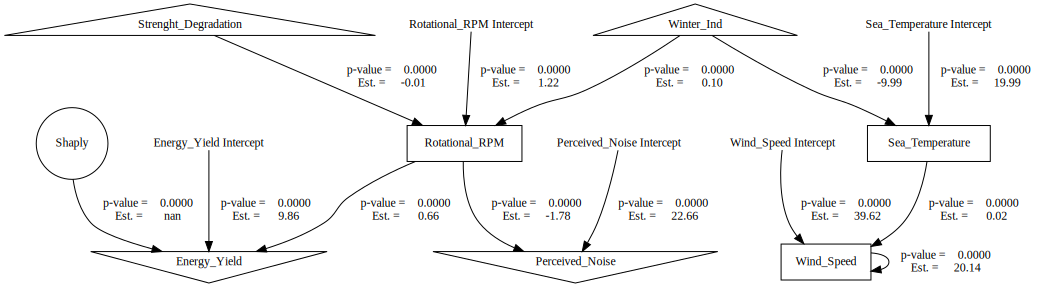

In [20]:
scm_results_plot(df.columns, bootstrap_estimate, 'FDCR_model_estimates_01')

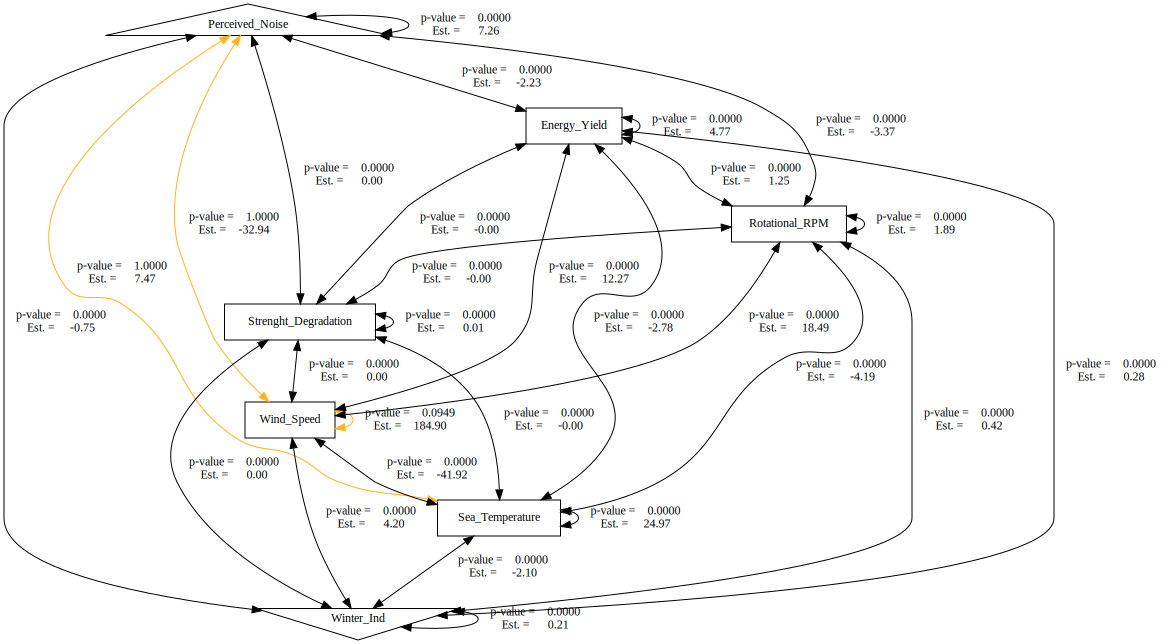

In [21]:
scm_induced_covariances_plot(df.columns, bootstrap_estimate, 'FDCR_scm_induced_covariances_01')

# Step 2 - the right model

In [22]:
dfx=copy.copy(df[['Winter_Ind', 'Sea_Temperature', 'Wind_Speed', 'Strenght_Degradation', 'Rotational_RPM','Energy_Yield', 'Perceived_Noise']])
nxDAG = nx.DiGraph([('Winter_Ind'            , 'Sea_Temperature' ),
                    ('Winter_Ind'            , 'Wind_Speed'      ),
                    ('Wind_Speed'            , 'Rotational_RPM'  ),
                    ('Strenght_Degradation'  , 'Energy_Yield'    ),
                    ('Rotational_RPM'        , 'Energy_Yield'    ),
                    ('Wind_Speed'            , 'Perceived_Noise' ),
                    ('Rotational_RPM'        , 'Perceived_Noise' ),
                    ('Strenght_Degradation'  , 'Perceived_Noise' ),
                    ])

scm = gcm.StructuralCausalModel(nxDAG) 

scm.set_causal_mechanism('Winter_Ind'                , gcm.EmpiricalDistribution())
scm.set_causal_mechanism('Strenght_Degradation'      , gcm.EmpiricalDistribution())
scm.set_causal_mechanism('Sea_Temperature'           , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
scm.set_causal_mechanism('Wind_Speed'                , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
scm.set_causal_mechanism('Rotational_RPM'            , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
scm.set_causal_mechanism('Energy_Yield'              , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
scm.set_causal_mechanism('Perceived_Noise'           , gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(scm, dfx)

print("Sea_Temperature")
print(scm.causal_mechanism('Sea_Temperature').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Sea_Temperature').prediction_model.sklearn_model.coef_)
print("Wind_Speed")
print(scm.causal_mechanism('Wind_Speed').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Wind_Speed').prediction_model.sklearn_model.coef_)
print("Rotational_RPM")
print(scm.causal_mechanism('Rotational_RPM').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Rotational_RPM').prediction_model.sklearn_model.coef_)
print("Energy_Yield")
print(scm.causal_mechanism('Energy_Yield').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Energy_Yield').prediction_model.sklearn_model.coef_)
print("Perceived_Noise")
print(scm.causal_mechanism('Perceived_Noise').prediction_model.sklearn_model.intercept_)
print(scm.causal_mechanism('Perceived_Noise').prediction_model.sklearn_model.coef_)

def scm_parameters(scm):
    return (
        scm.causal_mechanism('Sea_Temperature').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Sea_Temperature').prediction_model.sklearn_model.coef_[0],
        scm.causal_mechanism('Wind_Speed').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Wind_Speed').prediction_model.sklearn_model.coef_[0],
        scm.causal_mechanism('Rotational_RPM').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Rotational_RPM').prediction_model.sklearn_model.coef_[0],
        scm.causal_mechanism('Energy_Yield').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Energy_Yield').prediction_model.sklearn_model.coef_[0],
        scm.causal_mechanism('Energy_Yield').prediction_model.sklearn_model.coef_[1],
        scm.causal_mechanism('Perceived_Noise').prediction_model.sklearn_model.intercept_,
        scm.causal_mechanism('Perceived_Noise').prediction_model.sklearn_model.coef_[0],
        scm.causal_mechanism('Perceived_Noise').prediction_model.sklearn_model.coef_[1],
        scm.causal_mechanism('Perceived_Noise').prediction_model.sklearn_model.coef_[2]
        )
print()
print("scm_parameters")
print(scm_parameters(scm))
print()
scm_parameter_names = ['Sea_Temperature~Intercept',
                       'Sea_Temperature~Winter_Ind',
                       'Wind_Speed~Intercept',
                       'Wind_Speed~Winter_Ind',
                       'Rotational_RPM~Intercept',
                       'Rotational_RPM~Wind_Speed',
                       'Energy_Yield~Intercept',
                       'Energy_Yield~Rotational_RPM',
                       'Energy_Yield~Strenght_Degradation',
                       'Perceived_Noise~Intercept',
                       'Perceived_Noise~Rotational_RPM',
                       'Perceived_Noise~Strenght_Degradation',
                       'Perceived_Noise~Wind_Speed']
print()
print(scm_parameter_names)
print()
bootstrap_estimate = bootstrap_scms_FDCR(n_boot=2000, input_df = dfx, scm_parameters_func=scm_parameters, scm_parameter_names = scm_parameter_names, belifeDic = belifeDic)
print("-- Boostrap DONE ---")

Sea_Temperature
19.992924643081306
[-9.99164065]
Wind_Speed
39.95905910813726
[19.97407407]
Rotational_RPM
1.200637017022582
[0.10000652]
Energy_Yield
10.051928821731124
[ 0.66373627 -0.12763374]
Perceived_Noise
19.965616758943575
[ 0.65296497  0.03481776 -0.24873658]

scm_parameters
(19.992924643081306, -9.991640652327526, 39.95905910813726, 19.97407407288626, 1.200637017022582, 0.10000651916685746, 10.051928821731124, 0.6637362694180536, -0.12763373511428527, 19.965616758943575, 0.6529649673398303, 0.03481775652315902, -0.24873658469064966)


['Sea_Temperature~Intercept', 'Sea_Temperature~Winter_Ind', 'Wind_Speed~Intercept', 'Wind_Speed~Winter_Ind', 'Rotational_RPM~Intercept', 'Rotational_RPM~Wind_Speed', 'Energy_Yield~Intercept', 'Energy_Yield~Rotational_RPM', 'Energy_Yield~Strenght_Degradation', 'Perceived_Noise~Intercept', 'Perceived_Noise~Rotational_RPM', 'Perceived_Noise~Strenght_Degradation', 'Perceived_Noise~Wind_Speed']

-- Boostrap DONE ---


In [23]:
bootstrap_estimate

,edge,Estimate,p-value,lval,rval,op,raw_pvalue,adjFDR,key,belife,adjFCDR
0,Sea_Temperature~Intercept,19.9926,0.0000e+00,Sea_Temperature,Intercept,~,0.0000e+00,0.0000e+00,Sea_Temperature~Intercept,1.0,0.0000e+00
1,Sea_Temperature~Winter_Ind,-9.9912,0.0000e+00,Sea_Temperature,Winter_Ind,~,0.0000e+00,0.0000e+00,Sea_Temperature~Winter_Ind,3.0,0.0000e+00
2,Wind_Speed~Intercept,39.9596,0.0000e+00,Wind_Speed,Intercept,~,0.0000e+00,0.0000e+00,Wind_Speed~Intercept,1.0,0.0000e+00
3,Wind_Speed~Winter_Ind,19.9736,0.0000e+00,Wind_Speed,Winter_Ind,~,0.0000e+00,0.0000e+00,Wind_Speed~Winter_Ind,3.0,0.0000e+00
4,Rotational_RPM~Intercept,1.2006,0.0000e+00,Rotational_RPM,Intercept,~,0.0000e+00,0.0000e+00,Rotational_RPM~Intercept,1.0,0.0000e+00
...,...,...,...,...,...,...,...,...,...,...,...
37,covariance,-3.3659,0.0000e+00,Rotational_RPM,Perceived_Noise,~~,0.0000e+00,0.0000e+00,Rotational_RPM~~Perceived_Noise,1.0,0.0000e+00
38,covariance,4.7679,0.0000e+00,Energy_Yield,Energy_Yield,~~,0.0000e+00,0.0000e+00,Energy_Yield~~Energy_Yield,1.0,0.0000e+00
39,covariance,-2.2337,0.0000e+00,Energy_Yield,Perceived_Noise,~~,0.0000e+00,0.0000e+00,Energy_Yield~~Perceived_Noise,1.0,0.0000e+00
40,covariance,7.2546,1.2928e-247,Perceived_Noise,Perceived_Noise,~~,9.8114e-248,1.2571e-247,Perceived_Noise~~Perceived_Noise,1.0,1.2928e-247


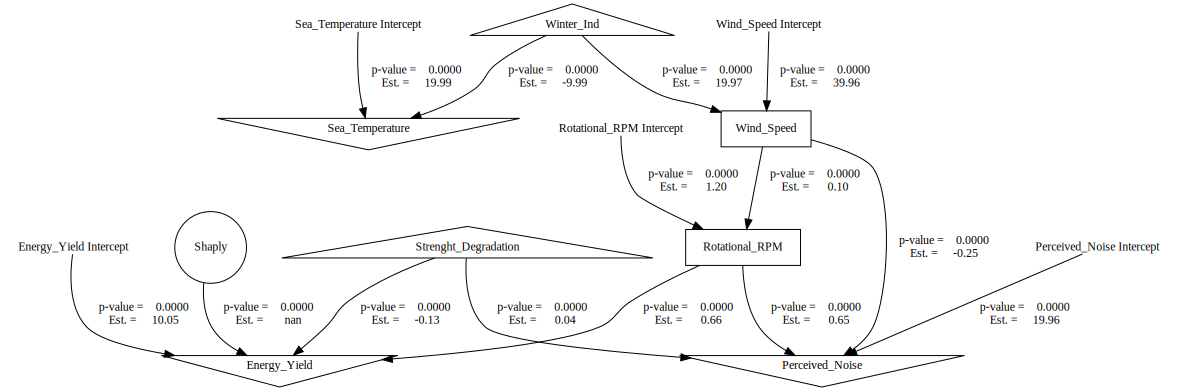

In [24]:
scm_results_plot(df.columns, bootstrap_estimate, 'FDCR_model_estimates_02')

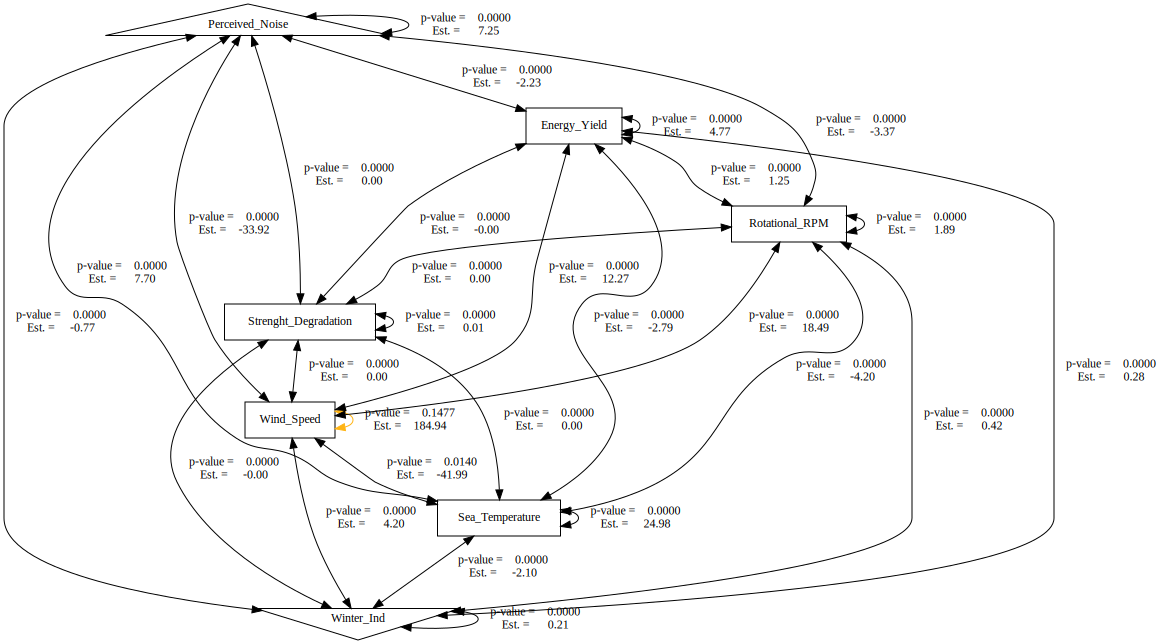

In [25]:
scm_induced_covariances_plot(df.columns, bootstrap_estimate, 'FDCR_scm_induced_covariances_01')